In [39]:
import pandas as pd
import xml.etree.ElementTree as ET
import re

log_file = None # Path to results.xml
tree = ET.parse(log_file)
root = tree.getroot()

rows = []

# Regular expression to extract the type inside DenseMatrix<...>
dm_pattern = re.compile(r"DenseMatrix<([^>]+)>")
# Regular expression to extract the CSV file name from a top-level section name
csv_pattern = re.compile(r"\s*(.+)")

def process_section(section, csv_file=None, parent_name=""):
    current_name = section.attrib.get("name", "")
    # At the top-level, try to extract the CSV file name.
    if csv_file is None and not parent_name:
        m = csv_pattern.match(current_name)
        if m:
            csv_file = m.group(1).strip()
            composite_name = ""  # reset composite name for inner sections
        else:
            # If no CSV file label, use current name as composite name.
            composite_name = current_name
    else:
        composite_name = current_name if not parent_name else f"{parent_name} > {current_name}"

    results = []
    child_sections = section.findall("Section")
    if child_sections:
        for child in child_sections:
            results.extend(process_section(child, csv_file=csv_file, parent_name=composite_name))
    else:
        overall_results = section.find("OverallResults")
        duration = overall_results.attrib.get("durationInSeconds", "") if overall_results is not None else ""
        failures = overall_results.attrib.get("failures", "") if overall_results is not None else ""
        results.append((csv_file, composite_name, duration, failures))
    return results

# Iterate over each TestCase element in the XML
for testcase in root.findall(".//TestCase"):
    test_case_name = testcase.attrib.get("name", "")
    # Extract DenseMatrix string type
    m = dm_pattern.search(test_case_name)
    string_type = m.group(1) if m else None

    # If there are nested Section elements, process them.
    testcase_sections = testcase.findall("Section")
    if testcase_sections:
        for sec in testcase_sections:
            # Process each top-level section; if it has a CSV file name, it will be extracted.
            section_tuples = process_section(sec)
            for csv_file, inner_section, duration, failures in section_tuples:
                rows.append({
                    "CSVFile": csv_file,
                    "section": inner_section,
                    "durationinseconds": duration,
                    "failures": failures,
                    "testcase": test_case_name,
                    "Stringtype": string_type
                })
    else:
        # If no sections are present, look for an OverallResult directly under the TestCase.
        overall_result = testcase.find("OverallResult")
        duration = overall_result.attrib.get("durationInSeconds", "") if overall_result is not None else ""
        failures = overall_result.attrib.get("failures", "") if overall_result is not None else ""
        rows.append({
            "CSVFile": None,
            "section": None,
            "durationinseconds": duration,
            "failures": failures,
            "testcase": test_case_name,
            "Stringtype": string_type
        })

# Create the DataFrame and drop rows without a valid Stringtype.
df = pd.DataFrame(rows).dropna(subset=["Stringtype"])

# Optionally extract an alternative from the test case name if needed.
df['alternative'] = df['testcase'].str.extract(r'-\s*(EwBinaryMat|EwBinarySca)\)', expand=False)
df['CSVFile'] = df['CSVFile'].str.split('/').str[-1]
# Define a regex pattern with named capture groups for each parameter
pattern = (
    r"dataset_rows_(?P<rows>\d+)_"
    r"cols_(?P<cols>\d+)_"
    r"mean_(?P<mean>\d+)_"
    r"std_(?P<std>\d+)_"
    r"dup_(?P<dup>\d+)_"
    r"dist_(?P<dist>\w+)_"
    r"seed_(?P<seed>\d+)_"
    r"min_(?P<min>\d+)_"
    r"max_(?P<max>\d+)\.csv"
    r"_numRowsRead_(?P<numRowsRead>\d+)"
)

# Extract the parameters into a new DataFrame
params = df['CSVFile'].str.extract(pattern)

# Join the extracted parameters back to the original DataFrame
df = df.join(params)
# Define your custom ordering for the string type.
order = ["std::string", "FixedStr16", "FixedStr32", "FixedStr64", 
         "FixedStr128", "FixedStr256", "Umbra_t", "NewUmbra_t", 
         "UnorderedDictionaryEncodedString", "OrderedDictionaryEncodedString"]

df["Stringtype"] = pd.Categorical(df["Stringtype"], categories=order, ordered=True)

pd.set_option('display.max_rows', 100)
df_sorted = df.sort_values(by=["CSVFile", "section", "alternative", "Stringtype"])
df_sorted[df_sorted["failures"]=="0"]

,CSVFile,section,durationinseconds,failures,testcase,Stringtype,alternative,rows,cols,mean,std,dup,dist,seed,min,max,numRowsRead
6426,dataset_rows_100000_cols_5_mean_500_std_1_dup_...,Concat,0.014928,0,StringsExperiments (Operations2) - DenseMatrix...,std::string,NaN,100000,5,500,1,0,normal,3,1,1000,1000
7050,dataset_rows_100000_cols_5_mean_500_std_1_dup_...,Concat,0.013303,0,StringsExperiments (Operations2) - DenseMatrix...,Umbra_t,NaN,100000,5,500,1,0,normal,3,1,1000,1000
7122,dataset_rows_100000_cols_5_mean_500_std_1_dup_...,Concat,0.028785,0,StringsExperiments (Operations2) - DenseMatrix...,NewUmbra_t,NaN,100000,5,500,1,0,normal,3,1,1000,1000
2976,dataset_rows_100000_cols_5_mean_500_std_1_dup_...,EQ,0.000427,0,StringsExperiments (EwBinaryMat) - DenseMatrix...,std::string,NaN,100000,5,500,1,0,normal,3,1,1000,1000
4200,dataset_rows_100000_cols_5_mean_500_std_1_dup_...,EQ,0.000489,0,StringsExperiments (EwBinaryMat) - DenseMatrix...,Umbra_t,NaN,100000,5,500,1,0,normal,3,1,1000,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,dataset_rows_100000_cols_5_mean_5_std_1_dup_75...,readCsv(),0.036242,0,StringsExperiments (ReadCsv) - DenseMatrix<Fix...,FixedStr256,NaN,100000,5,5,1,75,uniform,3,1,10,100000
620,dataset_rows_100000_cols_5_mean_5_std_1_dup_75...,readCsv(),0.024167,0,StringsExperiments (ReadCsv) - DenseMatrix<Umb...,Umbra_t,NaN,100000,5,5,1,75,uniform,3,1,10,100000
692,dataset_rows_100000_cols_5_mean_5_std_1_dup_75...,readCsv(),0.02285,0,StringsExperiments (ReadCsv) - DenseMatrix<New...,NewUmbra_t,NaN,100000,5,5,1,75,uniform,3,1,10,100000
764,dataset_rows_100000_cols_5_mean_5_std_1_dup_75...,readCsv(),0.124245,0,StringsExperiments (ReadCsv) - DenseMatrix<Uno...,UnorderedDictionaryEncodedString,NaN,100000,5,5,1,75,uniform,3,1,10,100000


C:\Users\Tim\AppData\Local\Temp\ipykernel_16952\712331287.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = sec_df.groupby('Stringtype')['durationinseconds'].mean().reset_index()


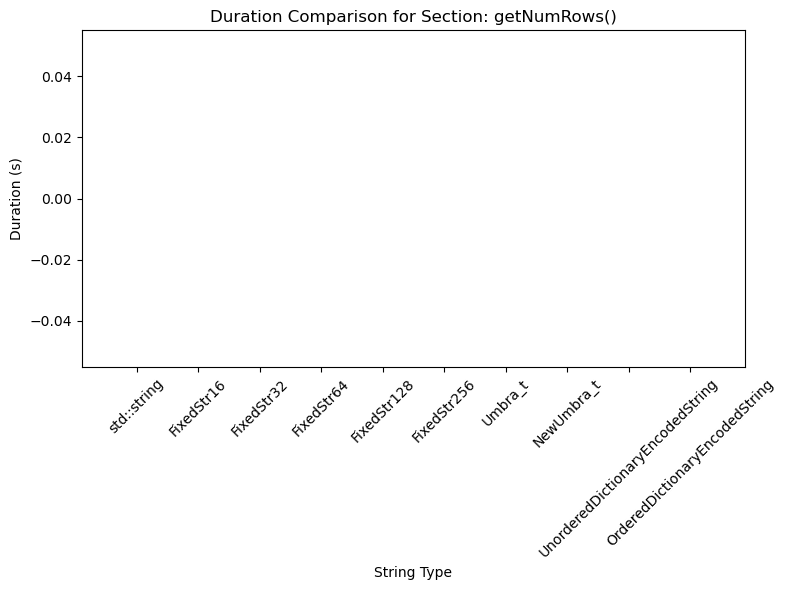

C:\Users\Tim\AppData\Local\Temp\ipykernel_16952\712331287.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = sec_df.groupby('Stringtype')['durationinseconds'].mean().reset_index()


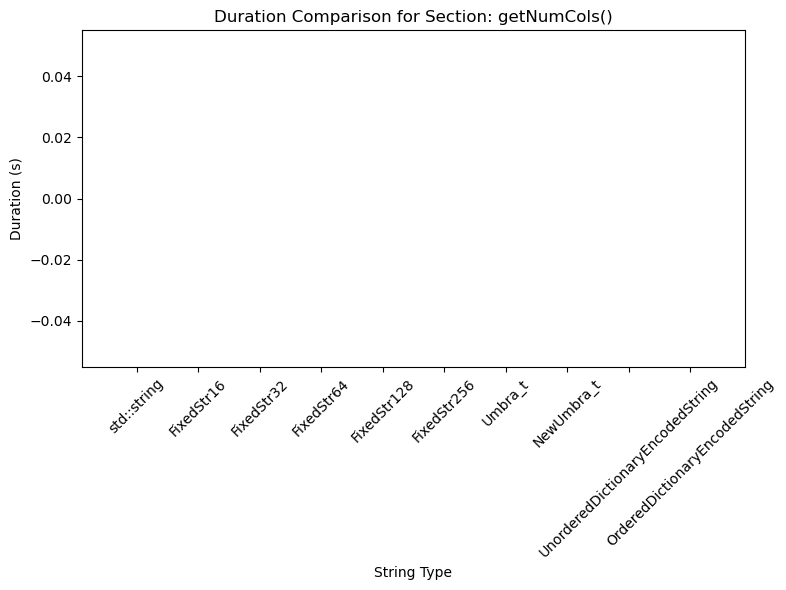

C:\Users\Tim\AppData\Local\Temp\ipykernel_16952\712331287.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = sec_df.groupby('Stringtype')['durationinseconds'].mean().reset_index()


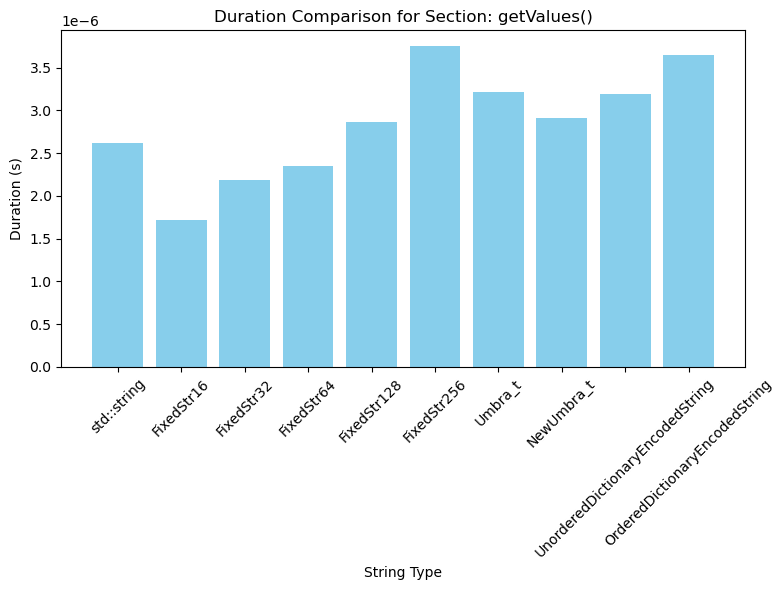

C:\Users\Tim\AppData\Local\Temp\ipykernel_16952\712331287.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = sec_df.groupby('Stringtype')['durationinseconds'].mean().reset_index()


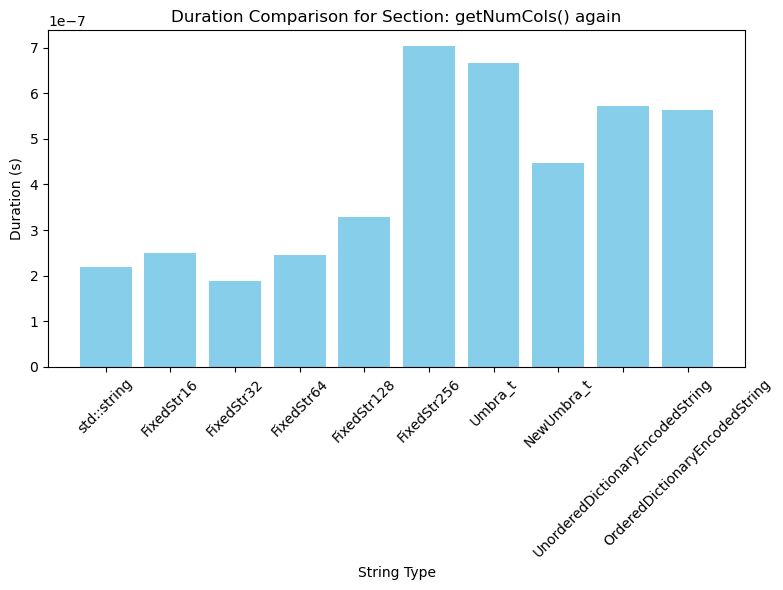

C:\Users\Tim\AppData\Local\Temp\ipykernel_16952\712331287.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = sec_df.groupby('Stringtype')['durationinseconds'].mean().reset_index()


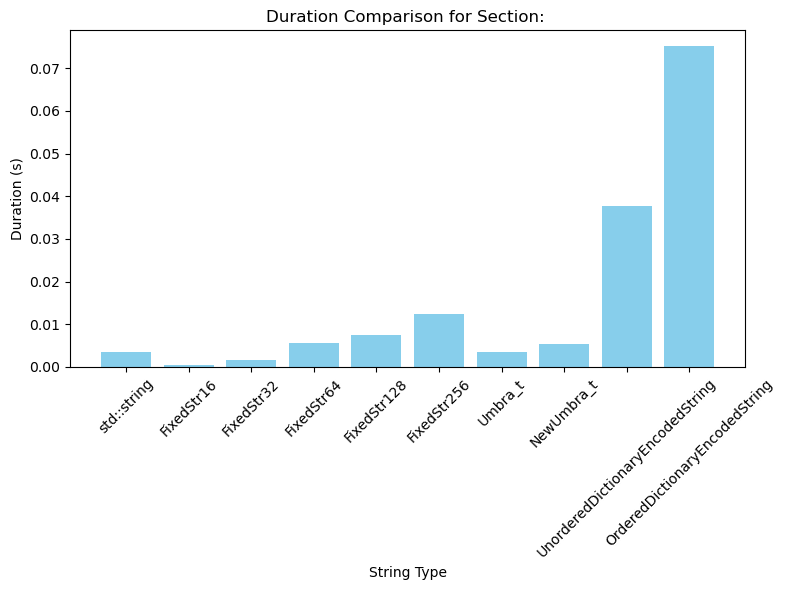

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the duration column is numeric
df['durationinseconds'] = pd.to_numeric(df['durationinseconds'], errors='coerce')

# Get unique sections, excluding those that are NaN
sections = df['section'].dropna().unique()

# Create a bar chart for each section
for sec in sections:
    # Filter the DataFrame for this section
    sec_df = df[df['section'] == sec]
    
    # In case there are multiple rows per string type, take the average duration.
    grouped = sec_df.groupby('Stringtype')['durationinseconds'].mean().reset_index()
    
    plt.figure(figsize=(8, 6))
    plt.bar(grouped['Stringtype'], grouped['durationinseconds'], color='skyblue')
    plt.title(f"Duration Comparison for Section: {sec}")
    plt.xlabel("String Type")
    plt.ylabel("Duration (s)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
